# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 7</span>

**Molecular Dynamics - NVT**
    
With these exercises we want to study the thermodynamic behaviour of a system of interacting particles as we did in exercise (4). The difference is that here we run simulations in the canonical ensemble (costant number of particles $N$, volume $V$ and temperature $T$). Because of that, we use a different method to operate: since the total energy of the system is no more constant, we can use the Metropolis algorithm to evalute the time evolution of the particles configuration instead of the Verlet one.

### Exercise 07.1

As a first step, we want to use the provided  Monte Carlo NVT code to print out instantaneous values of potential energy per particle, $U^*/N$, and pressure, $P^*$, along Monte Carlo simulations for a system in its three phases:
- solid phase: $\rho^* = 1.1$, $T^* = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^* = 0.8$, $T^* = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^* = 0.05$, $T^* = 1.2$ (cut-off radius: $r_c = 5.0$)

This is also important, before starting measuring mean values for thermodynamic properties, to set the parameters for the equilibration process, as shown below.

As in exercise (4), thermodynamic properties are expressed in LJ units.

As explaned in exercise (5), the choice of the time step $\delta$ of the transition probability is important for the Metropolis algorithm. These parameters are manually calibrated for each phase to obtain an acceptance rate of $\sim 50 \%$:
- $ \delta_{solid} = 0.1 $
- $ \delta_{liquid} = 0.2 $
- $ \delta_{gas} = 7.5 $

**1. Equilibration**

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
phases=['Solid','Liquid','Gas']
titles=['Potential energy','Pressure']
obs=['epot','press']
labels=['U*/N','P*']
colors2=[['teal','forestgreen','limegreen'],['firebrick','orangered','orange']]

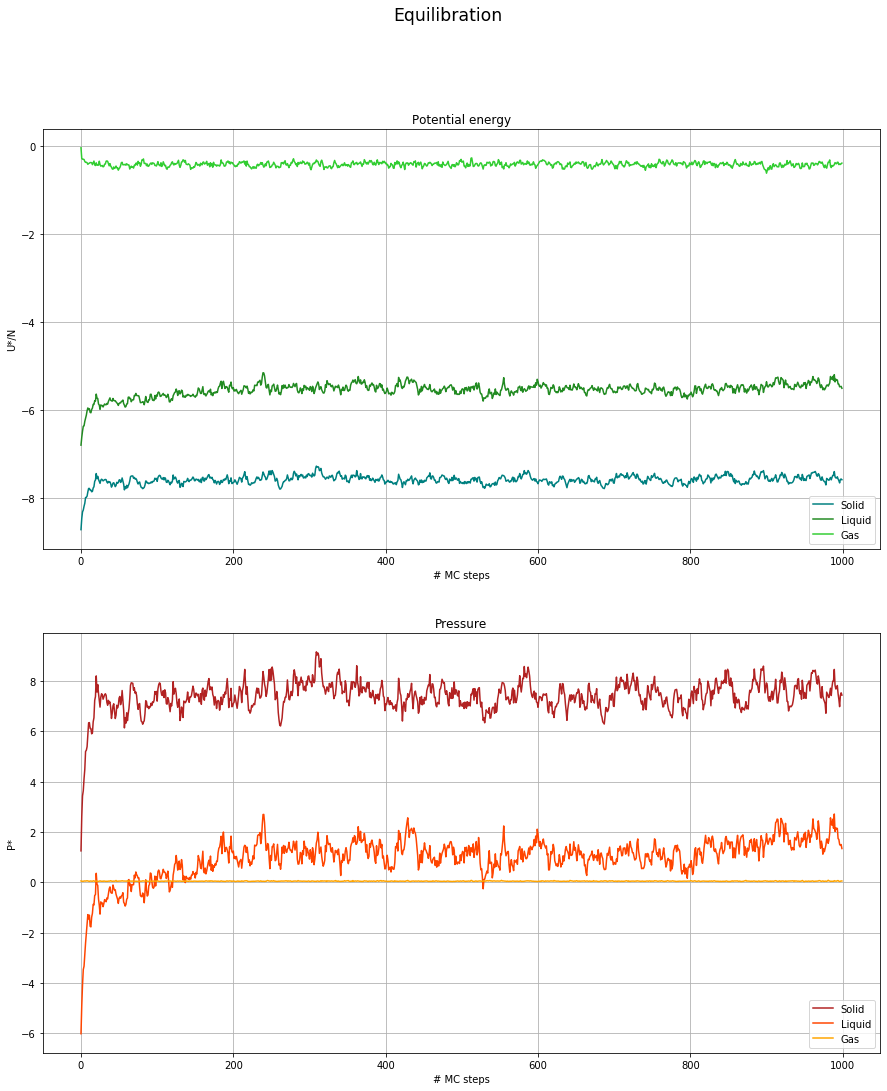

In [8]:
fig=plt.subplots(figsize=(15, 17))
plt.suptitle("Equilibration",size='xx-large')
p=211

for j in range (2):
    plt.subplot(p)
    for i in range (3):
        y = np.loadtxt("equilibration/"+phases[i]+"/instant_"+obs[j]+".out", max_rows=1000, unpack=True)
        plt.plot(y, color=colors2[j][i], label=phases[i])
        plt.xlabel('# MC steps')
        plt.ylabel(labels[j])
        plt.title(titles[j])
        plt.grid(True)
        plt.legend()
    p+=1
        
plt.show()

Before starting measuring its thermodynamic properties, it is required to equilibrate the system. The eqilibration process, if compared to the NVE one (exercise (4)), is less demanding and has the same structure of the one used for exercise (5): the Metropolis algorithm has to be run a certain number of steps until it starts producing stable results' values. Thus, to implement this, we add to the code a function that automatically performs the equilibration for $N_{steps}=300$; in fact, as we can see from the previous pictures, after $\sim 300$ MC steps the algorithm gives the expected results.

**2. Autocorrelation function**

We can now use the computed $M=10^5$ instantaneous values of potential energy per particle, $U^*/N$, and pressure, $P^*$, for the (equilibrated) system in its three phases to compute their autocorrelation function, in order to approximately estimate how large the blocks in our simulations should be.

The autocorrelation function gives in fact an estimation of the number of steps required to obtain results that are not affected by correlation:

$$ AC(t) = \chi(t)=\frac{\langle \ x(\ t' \ ) \cdot x(\ t'+t \ ) \ \rangle -\langle x( \ t' \ ) \rangle \cdot \langle x( \ t'+ t \ ) \rangle }{\sigma_ x^2}$$

where $t$ is the MC time (i.e. a number of MC steps) between two consecutive measurements of the observable $x$. Thus, $AC(t)$ is large when there is high correlation between the two measurements ($AC(t)$=1 for $t=0$, maximum correlation) and decreases to zero when the the second measurement is done after long MC time.

In [9]:
def autocorrelation(x, nsteps):
    sigma=np.std(x)
    t_max=len(x)
    ac=np.zeros(nsteps)
    
    for dt in range(nsteps):
        sum1=0.0
        sum2=0.0
        sum3=0.0
        tf=t_max-dt
        
        for t in range(tf):
            sum1+=x[t]*x[t+dt]
            sum2+=x[t]
            sum3+=x[t+dt]
        
        ac[dt]=(sum1/tf-sum2*sum3/(tf**2))/(sigma**2)
        
    return ac

t_steps=300

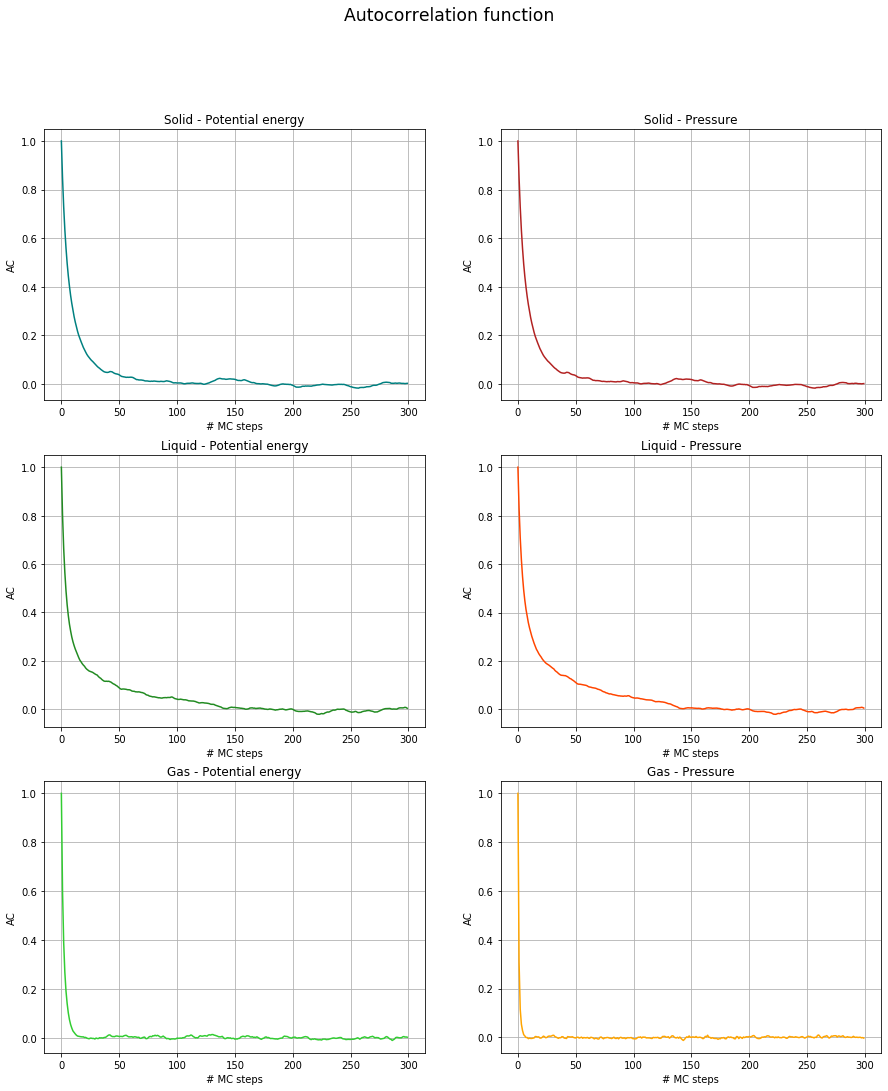

In [10]:
fig=plt.subplots(figsize=(15, 17))
plt.suptitle("Autocorrelation function", size='xx-large')
p=321

for i in range (3):
    for j in range(2):
        plt.subplot(p)
        y = np.loadtxt(phases[i]+"/instant_"+obs[j]+".out", unpack=True)
        ac = autocorrelation(y,t_steps)
        plt.plot(ac, color=colors2[j][i], label=phases[i])
        plt.xlabel('# MC steps')
        plt.ylabel("AC")
        plt.title(phases[i]+" - "+titles[j])
        plt.grid(True)
        p+=1
        
plt.show()

As we can deduce from the graphs above, the number of MC steps that we need to obtain uncorrelated results, represented by AC $\sim 0$, are the following for each phase:

- solid: $\sim 100$ MC steps

- liquid: $\sim 180$ MC steps

- gas: $\sim 30$ MC steps

Thus, for measuring the mean values of the thermodynamic properties with data blocking (see the next exercises below), it is better to have block of more than those numbers of MC steps.

**3. Statistical error**

We use the same data to study the estimation of the statistical uncertainties of the expectation value of $U^*/N$ and $P^*$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks:

$$\sigma =\sqrt{\frac{\langle x^2 \rangle - \langle x \rangle ^2}{N-1}}$$

In fact, as explained below, this is useful to choose the right size of the blocks too.

In [11]:
def Error(ave, ave2, n):
    if(n==0): 
        return 0
    else: 
        return np.sqrt((ave2-ave**2)/n)

def data_blocking(x, N, L):
    ave=0.0
    ave2=0.0
    error=0.0
    
    for n in range(N):
        blk_ave=0.0
        blk_ave2=0.0
        
        for l in range(L):
            blk_ave+=x[l+n*L]
        
        blk_ave/=L
        ave=(ave*n+blk_ave)/(n+1)
        ave2=(ave2*n+blk_ave**2)/(n+1)
        error=Error(ave, ave2,n)
        
    return error

L_m=10
L_M=5000
M=100000
L_step=10
L_steps=int((L_M-L_m)/L_step)

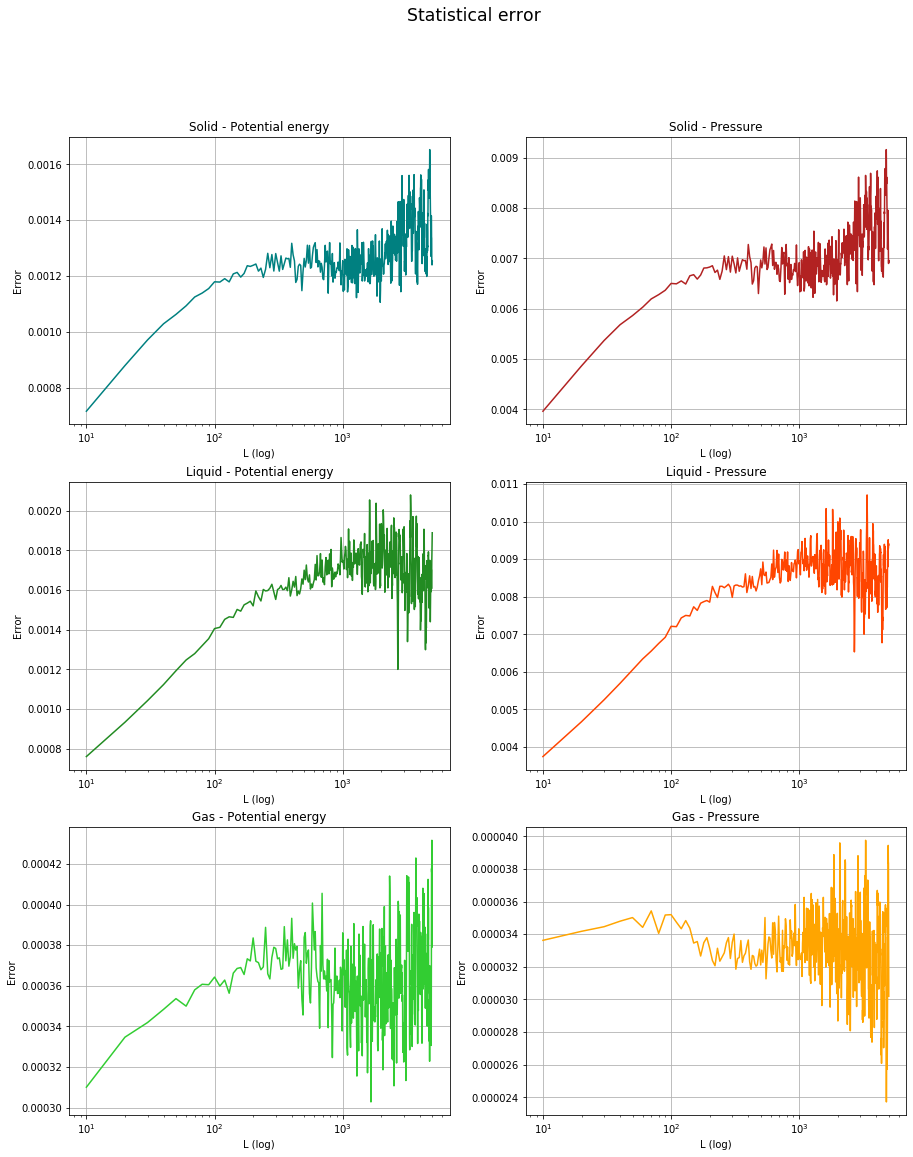

In [12]:
fig=plt.figure(figsize=(15, 18))
plt.suptitle("Statistical error", size='xx-large')
p=321

for i in range(3):
    for j in range(2):
        plt.subplot(p)
        y = np.loadtxt(phases[i]+"/instant_"+obs[j]+".out")
        error=[]
        x=[]
        
        for l in range(L_steps):
            L=L_m+l*L_step
            N=int(M/L)
            err=data_blocking(y,N,L)
            error.append(err)
            x.append(L)
            
        plt.plot(x, error, color=colors2[j][i])
        
        plt.ylabel("Error")
        plt.xlabel('L (log)')
        plt.xscale("log")
        plt.title(phases[i]+" - "+titles[j])
        plt.grid(True)
        p+=1
        
plt.show()

We see in the graphs that for the first values of $L$ the statistical uncertainty increases and for larger values it becomes stable, as expected. This happens, for the three phases, at:

- solid: $\sim 300$ MC steps

- liquid: $\sim 500$ MC steps

- gas: $\sim300$ MC steps

These are the number of MC steps that are needed to obtain blocks with respective mean values not correlated between each other, and so to apply the Central Limit Theorem: increasing the size of each block $L$ those values of MC steps does not lead to an increase of error bar width.

Thus, from now on, as we want to use the blocking method to compute the expectation values of the observables of the system, we consider for the simulations a smaller number of MC steps $M=2500$ divided in $N=50$ blocks of size $L=500$, that is sufficient for any phase of the system.

**Radial distribution function**

The radial distribution function $g(r)$ is the probability distribution of particles at a radial distance $r$ from a given particle, that we set as the one in the origin of the system:

$$g(r)=\frac{1}{\rho N \Delta V (r)} \langle \sum_{i=1}^N \sum_{j =1, j\neq i}^N \delta \  ( \ r-|\vec r_i -\vec r_j| \ ) \ \rangle$$
where $\Delta V(r)=\frac{4\pi}{3}\left[(r+dr)^3-r^3\right]$.

### Exercise 07.2

We include in our Monte Carlo NVT code the calculation of the radial distribution function, $g(r)$ as a function of the radial distance $r$ among particles, with $r \in \left[ 0; L_{box}/2\right]$.



The idea under the implementation of the method to calculate $g(r)$ is the following:
- we divide half of the box side $L_{box}$ into bins to build a histogram;
- we count the particles that lay in a certain interval of distances and every time we fill with two particles the corrispondent bin of the histogram;
- at the end of the simulation we normalize the histogram with the quantity $\rho N \Delta V$.

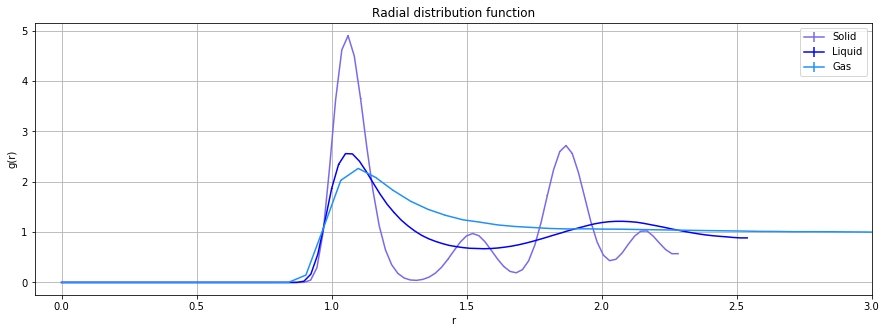

In [13]:
colors=['mediumslateblue','blue','dodgerblue']

fig=plt.figure(figsize=(15, 5))
plt.title("Radial distribution function")

#NB: output has 0) iblock 1) r 2) block_mean 3) global_mean 4) error_global_mean
for i in range(3):
    x,y,err = np.loadtxt(phases[i]+"/output.gave.0", usecols=(1,3,4),unpack=True)
    plt.errorbar(x,y,yerr=err, color=colors[i], label=phases[i])     

plt.xlabel('r')
plt.ylabel('g(r)')
plt.xlim(-0.1,3)
plt.grid(True)
plt.legend()

plt.show()

As expected, for any phase, $g(r)$ at distance of about $r<1$ is zero, meaning the two particles can not be closer (they can not overlap in fact). $g(r)$ reaches its maximum at $r \approx 1$, which means that the particles tend to stay at distance $1$ ($\sigma$ in SI units) between each other.

As $r$ increases, the three phases show different behaviours for $g(r)$: the solid's radial distribution function has higher peaks at small $r$ if compared to the others', as for this phase the particles are not free to move and are distributed in a cristalline structure; the opposite behaviour is in fact shown by the gas phase's $g(r)$.

At larger distances, all the curves stabilize around $1$, meaning that the particles tend to distribute in concentric shells around the particle in the origin of the system.

### Exercise 07.3

We include the calculation of the radial distribution function, $g(r)$, inside the previously used Molecular Dynamics NVE code too.

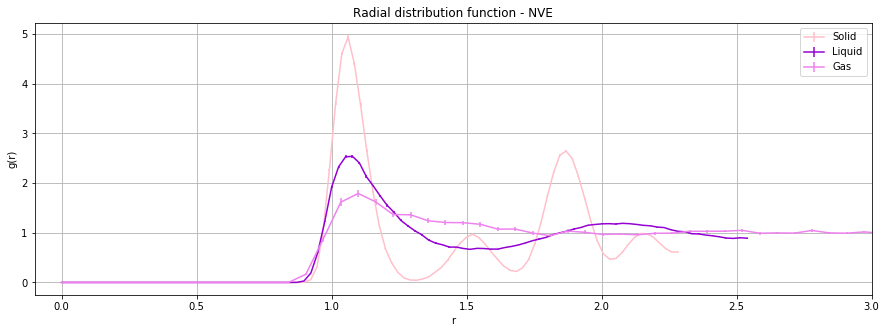

In [14]:
colors1=['pink','darkviolet','violet']

fig=plt.figure(figsize=(15, 5))
plt.title("Radial distribution function - NVE")

for i in range(3):
    x,y,err = np.loadtxt("NVE/"+phases[i]+"/ave_gave.out", usecols=(1,2,3),unpack=True)
    plt.errorbar(x,y,yerr=err, color=colors1[i], label=phases[i])     
    plt.xlabel('r')
    plt.ylabel('g(r)')
    plt.xlim(-0.1,3)
    plt.grid(True)
    plt.legend()

plt.show()

The results for $g(r)$ are similar to the ones obtained with the NVT code. Only $g(r)$ for the gas phase has a less regular behaviour, probably because it  is difficult to evaluate stable results for the gas phase with the NVE code.

### Exercise 07.4

With our improved MC code we now perform MC NVT simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the three phases. We then express the output results of the code in SI units.

We also want to compare the outputs for the the radial distribution function of the NVE and the NVT code.

In [15]:
#SI
kb=1.38064852E-23
amu=1.66054E-24
nm=1.0E-9

sigma=0.34*nm
epsilon_kb=120
mass=39.948*amu
epsilon=120*kb
fp=epsilon/sigma/sigma/sigma

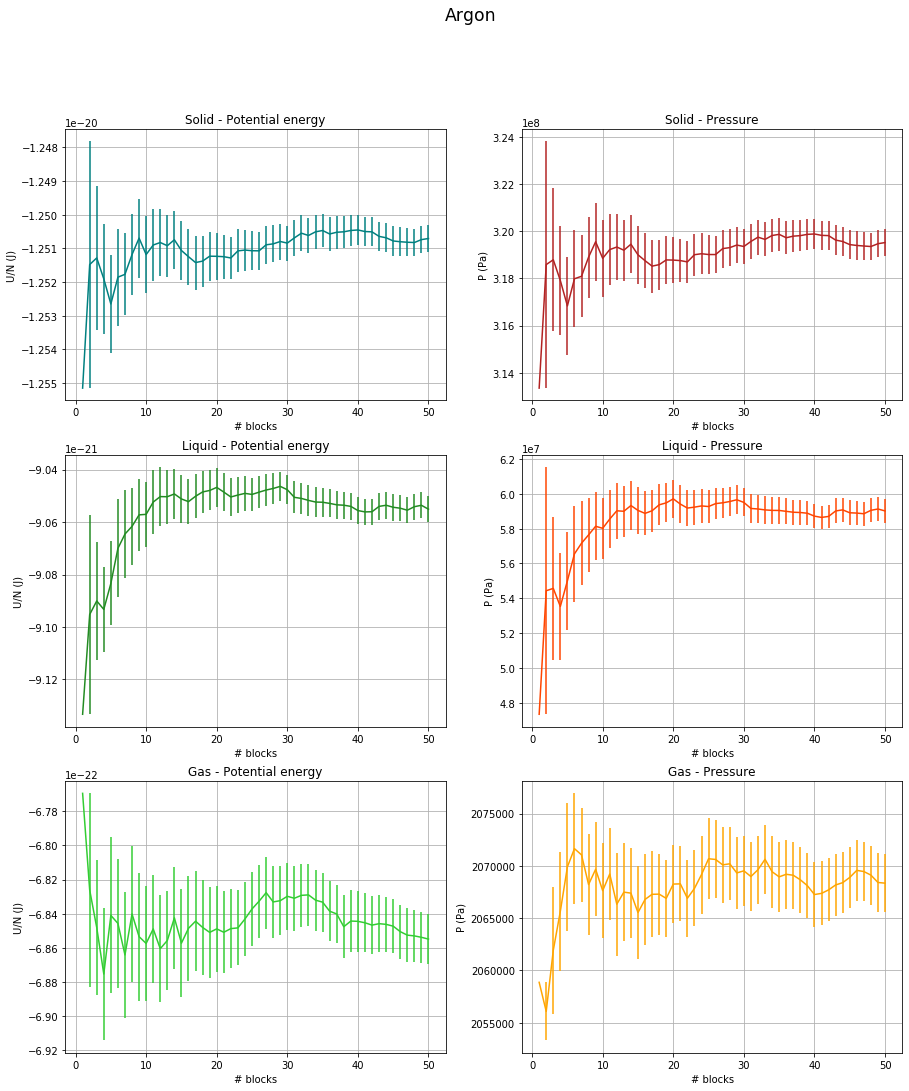

In [16]:
labels=['U/N (J)','P (Pa)']

fig=plt.subplots(figsize=(15, 17))
plt.suptitle("Argon",size='xx-large')
p=321

for i in range (3):
    for j in range(2):
        plt.subplot(p)
        
        x,y,err = np.loadtxt(phases[i]+"/output."+obs[j]+".0", usecols=(0,2,3),unpack=True)
        if (j==0):
            y*=epsilon
            err*=epsilon
        elif (j==1):
            y*=fp
            err*=fp
        
        plt.errorbar(x,y,yerr=err, color=colors2[j][i], label=phases[i])
        plt.xlabel('# blocks')
        plt.ylabel(labels[j])
        plt.title(phases[i]+" - "+titles[j])
        plt.grid(True)
        p+=1
        
plt.show()

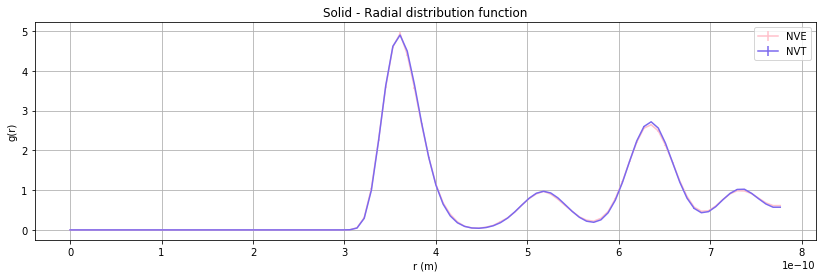

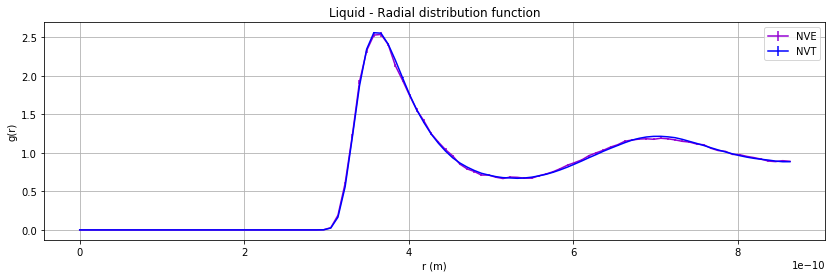

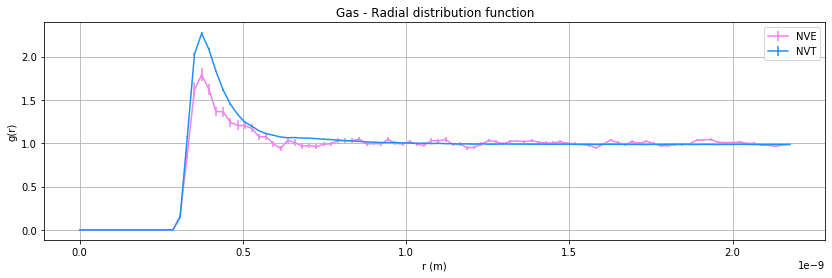

In [17]:
for i in range(3):
    fig=plt.figure(figsize=(14, 4))
    plt.title(phases[i]+" - Radial distribution function")
    x1,y1,err1 = np.loadtxt("NVE/"+phases[i]+"/ave_gave.out", usecols=(1,2,3),unpack=True)
    x,y,err = np.loadtxt(phases[i]+"/output.gave.0", usecols=(1,3,4),unpack=True)
    x1*=sigma
    x*=sigma
    plt.errorbar(x1,y1,yerr=err1, color=colors1[i], label="NVE")  
    plt.errorbar(x,y,yerr=err, color=colors[i], label="NVT")  
    plt.xlabel('r (m)')
    plt.ylabel('g(r)')
    #plt.xlim(0,3)
    plt.grid(True)
    plt.legend()

plt.show()